
## Clustering wells with low information

#### Eduardo Maldonado Cruz
#### Hildebrand Department of Petroleum and Geosystem Engineering, Cockrell School of Engineering, The University of Texas at Austin

### Subsurface Machine Learning Course, The University of Texas at Austin
#### Hildebrand Department of Petroleum and Geosystems Engineering, Cockrell School of Engineering
_____________________

Workflow supervision and review by:

#### Instructor: Prof. Michael Pyrcz, Ph.D., P.Eng., Associate Professor, The Univeristy of Texas at Austin
##### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

#### Course TA: Jack Xiao, Graduate Student, The University of Texas at Austin
##### [Twitter](https://twitter.com/jackxiao6) | [LinkedIn](https://www.linkedin.com/in/yuchen-jack-xiao-b1b20876/)


### Executive Summary

Many gas wells in the northern part of Mexico usually lack petophysical and operational information (e.g. workovers, repairs, interval change), this means that as engineers we often deal with production data that comes from unknown formations and poorly characterized reservoirs.
In addition, low gas prices limit the amount of information we can obtain from such wells. This often leads to inaccurate well classification and derive on bad analogue selection and misleading forecasting. 
In this workflow we follow a series of steps to derive two predictor features:
* Exponential decline exponent (It is unique for each well and might be similar for wells producing from the same formation)
* Initial rate (Captures the maximum variability in rate between the wells.)

Using the derived features we cluster the wells in the feature space. These clusters can provide a useful hint to identify misclassification of wells and raise flags on wells that behave differently from others, we can use our derived groups to compare and find similarities between fields and best analogues for forecasting. Other applications are forecasting problems in the wells based on the decline rate! We are learning from the data!.

### Description

This workflow is divided in the following steps:
* Load data
* Derive features
* Transform features using min-max normalization
* Use Nearest Neighbors to find $\epsilon$ hyperparameter
* Use DBSCAN to form groups in the feature space with sufficient point density using $\epsilon$ hyperparameter (local radius of the local neighbourhood in the metric of normalized features)

and uses the following files:

* CSV Production data with the shape

| Time | Well 1   | Well 2   |
|------|------|------|
|   1  | Production at time 1| Production at time 1|

* CSV with well information

| Well | Feature 1   | Feature 2   |
|------|------|------|
|   1  | Value of feature 1| Value of feature 2|



### Import Packages

We will need a couple of packages to perform clustering, plot, clean the data and optimize our solutions and visualization

In [1]:
#import os
import numpy as np # To work with arrays
import pandas as pd # Load data, and manage information
import matplotlib.pyplot as plt # To plot
import scipy.stats as stats #To get useful statistics
from scipy.optimize import minimize # To find best fit of the decline exponent
import matplotlib.font_manager # To use custom serif font family
import matplotlib as mpl
from numpy import diff # For numerical differentiation.
from sklearn.cluster import DBSCAN        # DBSCAN clustering
from sklearn.neighbors import NearestNeighbors # nearest neighbours function to calculate eps hyperparameter
from sklearn.cluster import SpectralClustering # Spectral Clustering function
from scipy.spatial import ConvexHull

In [2]:
plt.rcParams["text.usetex"]     = True
plt.rcParams["font.serif"] = "Computer Modern"
plt.rcParams["font.family"] = "serif"
plt.rcParams["figure.dpi"] = 300.0 

### Functions

The following functions will be used in the workflow.


In [3]:
def time_array(array):
    """
    Returns a time array in months
    """
    time=np.arange(0,len(array),1)
    return time

def min_max(array):
    """
    Returns an array with a min-max normalization
    """
    Norm=(array-array.min())/(array.max()-array.min())
    return Norm
def model(params, X):
    '''
    Returns the prediction of rate from exponential model
    '''
    a = params[0]
    y_pred = qi*e**(-a*X)# Exponential decline equation
    return y_pred
## Loss resistant to outliers
def MAE(params, X, Y):
    '''
    Mean absolute error loss function
    '''
    y_pred = model(params, X)
    obj = (abs(y_pred - Y).sum())/len(X)
    return obj
def RMSE(params, X, Y):
    y_pred = model(params, X)
    obj = (((y_pred - Y)**2).sum())/len(X)
    return obj


def encircle(x,y, ax=None, **kw):
    '''
    Adapted function from original post:
    https://stackoverflow.com/questions/22153522/convex-hull-concave-hull-for-multiple-clusters-in-data
    '''
    if not ax: ax=plt.gca()
    p = np.c_[x,y]
    hull = ConvexHull(p)
    poly = plt.Polygon(p[hull.vertices,:], **kw)
    ax.add_patch(poly)




### Load data

The following workflow uses two .csv files that contain
* Entire production data for all wells at different times in months, Production data is in MMscf, time is given in months.
* Names of the fields along with wells (This csv can cointain more than just field names, you can integrate petrophysical information, location or other features of interest)

Once we derive the features we will work with the following features



The first part of the process is use the entire production data to derive features that will be used for clustering analysis.

In [4]:
df = pd.read_csv('PGE_Project_Eduardo_Maldonado_Data_FieldRates.csv')
df=df.fillna(0)
df.describe()

,Time,Well 1,Well 2,Well 3,Well 4,Well 5,Well 6,Well 7,Well 8,Well 9,...,Well 2121,Well 2122,Well 2123,Well 2124,Well 2125,Well 2126,Well 2127,Well 2128,Well 2129,Well 2130
count,285.000000,285.000000,285.000000,285.000000,285.000000,285.000000,285.000000,285.000000,285.000000,285.000000,...,285.000000,285.000000,285.0,285.000000,285.0,285.000000,285.000000,285.000000,285.000000,285.000000
mean,143.000000,0.226982,0.655789,0.255018,0.831228,0.061779,0.026667,0.633193,0.038947,0.890119,...,0.133158,0.009358,0.0,0.028119,0.0,0.023632,0.004442,0.025765,0.012754,0.003175
std,82.416625,0.636519,1.495066,0.562689,1.497242,0.142294,0.064386,1.345731,0.086352,1.670672,...,0.325075,0.025354,0.0,0.084572,0.0,0.073563,0.035797,0.078155,0.040945,0.028559
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
25%,72.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.034000,...,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
50%,143.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.100000,...,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
75%,214.000000,0.100000,0.000000,0.000000,1.800000,0.100000,0.000000,0.000000,0.000000,1.100000,...,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
max,285.000000,3.400000,6.200000,3.400000,5.700000,1.100000,0.300000,6.200000,0.600000,9.800000,...,2.160000,0.189000,0.0,0.935000,0.0,0.533000,0.536000,0.533000,0.325000,0.315000


In [5]:
## Must be done over shifted data
cols_Well = df.columns[df.columns.str.startswith('Well')]
shift_cols_Well = df[cols_Well].ne(0).cumsum().eq(0).sum()
for col in cols_Well:
    df[col] = df[col].shift(-shift_cols_Well.loc[col])

Lets visualize our first 4 elements of our dataframe

In [6]:
df.head()

,Time,Well 1,Well 2,Well 3,Well 4,Well 5,Well 6,Well 7,Well 8,Well 9,...,Well 2121,Well 2122,Well 2123,Well 2124,Well 2125,Well 2126,Well 2127,Well 2128,Well 2129,Well 2130
0,1,1.9,0.4,2.2,4.9,1.1,0.3,0.4,0.6,4.4,...,0.090,0.023,NaN,0.935,NaN,0.533,0.032,0.374,0.325,0.086
1,2,3.4,4.3,3.4,5.6,0.6,0.2,5.9,0.2,9.8,...,2.160,0.120,NaN,0.535,NaN,0.457,0.046,0.533,0.301,0.315
2,3,3.1,5.3,3.2,5.2,0.2,0.1,6.2,0.2,8.6,...,1.920,0.100,NaN,0.346,NaN,0.446,0.016,0.432,0.254,0.231
3,4,2.9,6.0,2.7,5.3,0.1,0.1,5.9,0.2,7.4,...,1.173,0.189,NaN,0.219,NaN,0.328,0.014,0.522,0.231,0.273
4,5,2.5,6.0,2.4,5.3,0.1,0.1,5.1,0.2,7.4,...,1.244,0.021,NaN,0.162,NaN,0.303,0.016,0.356,0.136,NaN


In [7]:
Rate=df.loc[:,df.columns.str.startswith('Well')].to_numpy()
Rate=np.nan_to_num(Rate)
Time=time_array(Rate)

### Data example

Let's plot some of the production history for 5 wells.

In [8]:
'''
Minimum and maximum range of wells to plot, the following lines will
create a plot that covers production data from well 200 to well 205
'''
MinWells=200
MaxWells=205

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


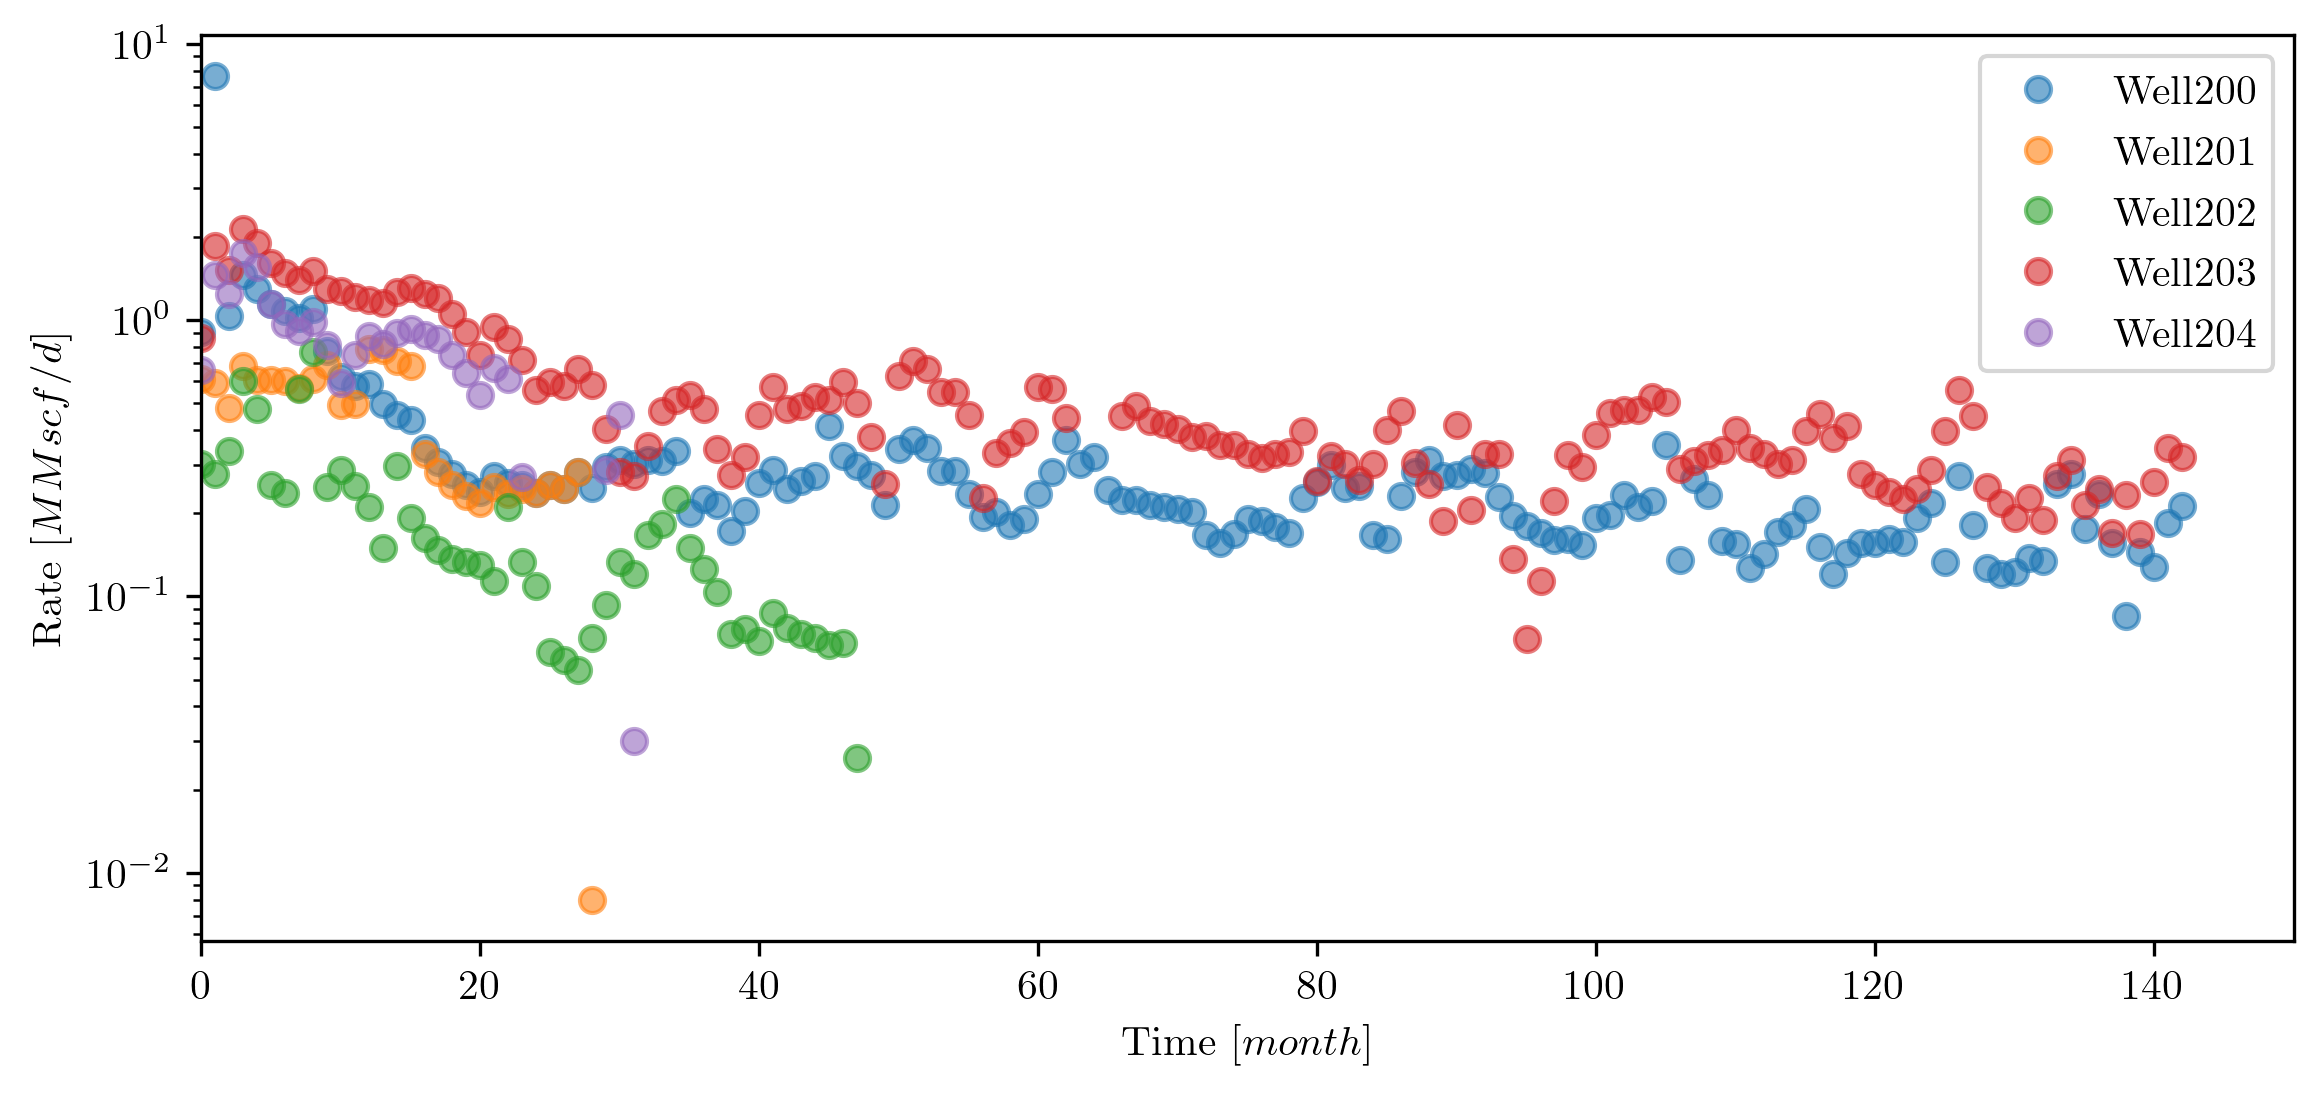

In [9]:
fig, ax = plt.subplots(figsize=(9, 4))
for i in range(MinWells,MaxWells):
    ax.semilogy(Time,Rate[:,i],'o',alpha=0.6,label=('Well'+str(i)) )
ax.set_ylabel('Rate $[MMscf/d]$')
ax.set_xlabel('Time $[month]$')
ax.set_xlim(0,150)
ax.legend()

In [10]:
Cumulative=np.zeros((Rate.shape[0],Rate.shape[1]))
days=365.25/12
for j in range(0,Rate.shape[1]):
    for i in range(0,Rate.shape[0]):
        if i==1:
            Cumulative[i,j]=days*Rate[i,j]
        else:
            Cumulative[i,j]=Cumulative[i-1,j]+days*Rate[i,j]

And include the cumulative recovery for each well

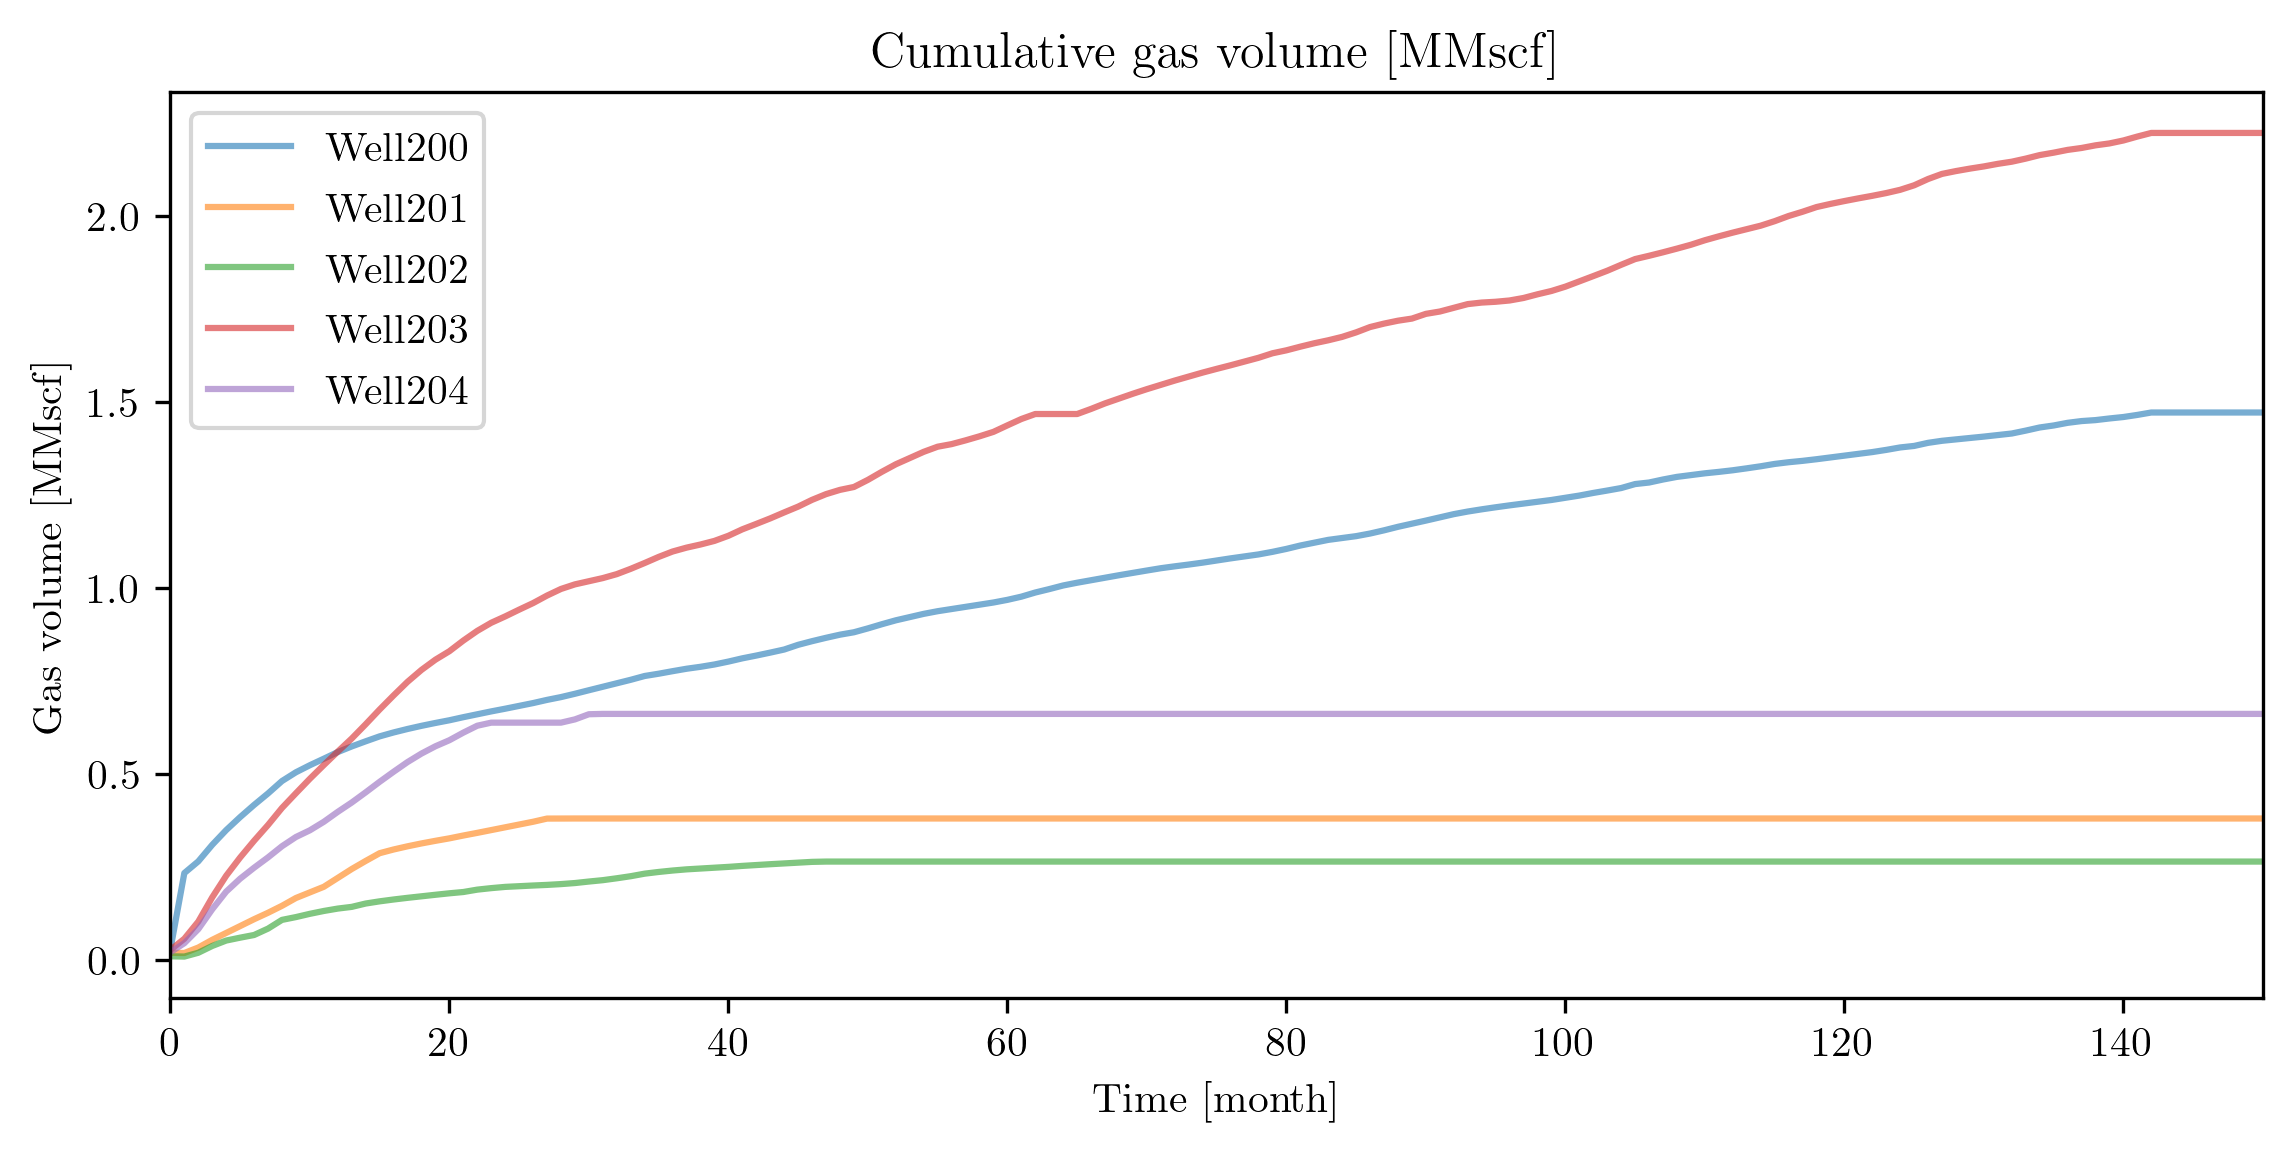

In [11]:
plt.figure(figsize=(9, 4))
for i in range(MinWells,MaxWells):
    plt.plot(Time,Cumulative[:,i]/1000,'-',alpha=0.6,label=('Well'+str(i)) )
plt.title('Cumulative gas volume [MMscf]')
plt.xlabel('Time [month]')
plt.ylabel('Gas volume [MMscf]')
plt.xlim(0,150)
plt.legend()
plt.show()

### Data generation

Let's import first our field names csv. As mentioned earlier we can include much more information into this csv to derive better conclusions

In [13]:
#Read the csv file
df_names = pd.read_csv('PGE_Project_Eduardo_Maldonado_Data_FieldNames.csv',encoding='utf-8')

We need a dictionary to add colors to our data.
Later on we can select multiple fields along with the wells and assign a specific color.

In [14]:
#Lets add a color map for different fields. There are over 206 fields
#you can add as many colors for the fields you want to investigate.
colmap = {
    'Field_test_1': 'indianred',
    'Field_test_2': 'mediumpurple',
    'Field1': 'navy',
    'Field2': 'rebeccapurple',
    'Field3': 'steelblue',
    'Field4': 'crimson',
}

### Deriving information from your field

A short summary of your workflow.

1. The following workflow is a simple approximation to find groups of wells within the data. 

2.  We often lack information from the wells, and most of the time flow rate is available. Why not use flow rate to compare and cluster similar wells? This way we can group, correlate wells and identify outliers in our data!.

2. Dynamic information aggregates multiple properties of the porous medium, $\mu$, $c_t$, $k$, $\phi$


#### Assumptions of our derived features

* Wells decline exponentially.
* No major operations on the wells. This workflow smooths the data to minimize outliers.
* No interference between wells

As part of the workflow we want to derive some features based on our observations of rate. Let's use a very simple decline model based on exponential decline.


#### Generation of decline exponents

Following the work proposed by Arps, we use an exponential decline to fit our wells.

\begin{equation}
q=q_i e^{-a_it}
\end{equation}

where 
$q$ is the the rate at time t,
$a$ is the decline exponent, and
$t$ is time,

In [15]:
e=np.e

index_to_drop=[]
index_to_keep=[]
well_index=[]
a=[]
b=[]
names=[]
color=[]
der=[]
#timeder=[]

i=1
for key in df_names.Field:
    '''
    You can include any filters here, currently there is just one field selected
    but you can extend it for any other field or property
    '''
    if key=='Field1':
        q=Rate[:,i]
        q=q[q!=0]
        qi=Rate[:,i].max()
        if len(q)<11:
            index_to_drop.append(i)
        if len(q)>11:
            N=8
            # Curve smoothing
            q_C=np.convolve(q,np.ones((N,))/N, mode='valid')
            derivative=diff(q_C)
            #print(derivative)
            t_C=time_array(q_C)
            X = t_C[:8] # 
            Y = q_C[:8] # 
            alpha_0 = 0.5
            # Decline exponent minimization
            res = minimize(MAE, [alpha_0, ], args=(X, Y), tol=1e-3, method="Nelder-Mead")
            # The nomial decline exponent is defined as the fractional hange in rate per unit of time
            # where this exponent is positive
            if res['x']<1:
                a.append(res['x'][0])
                #print(res['x'][0])
                names.append(str(key))
                color.append(str(colmap[str(key)]))
                der.append(max(abs(derivative)))
                #timeder.append(t_C[np.argmax(derivative)])
                #print(max((dR[:,i])))
                #b.append(sum(t_C))
                #b.append(sum(q))
                #The second parameter selected was initial rate
                b.append(qi)
                index_to_keep.append(i)
            else:
                index_to_drop.append(i)
            well_index.append(i)
        i=i+1


#### Plotting our derived features

We include a simple plot with our derived features to see what are the features we are working with.
Now. We have to use these features because our data is very limited. But you can include static and dynamic properties, skin or other production properties as features.

Text(0, 0.5, 'Initial rate $q_i$, $[MMscfd]$')

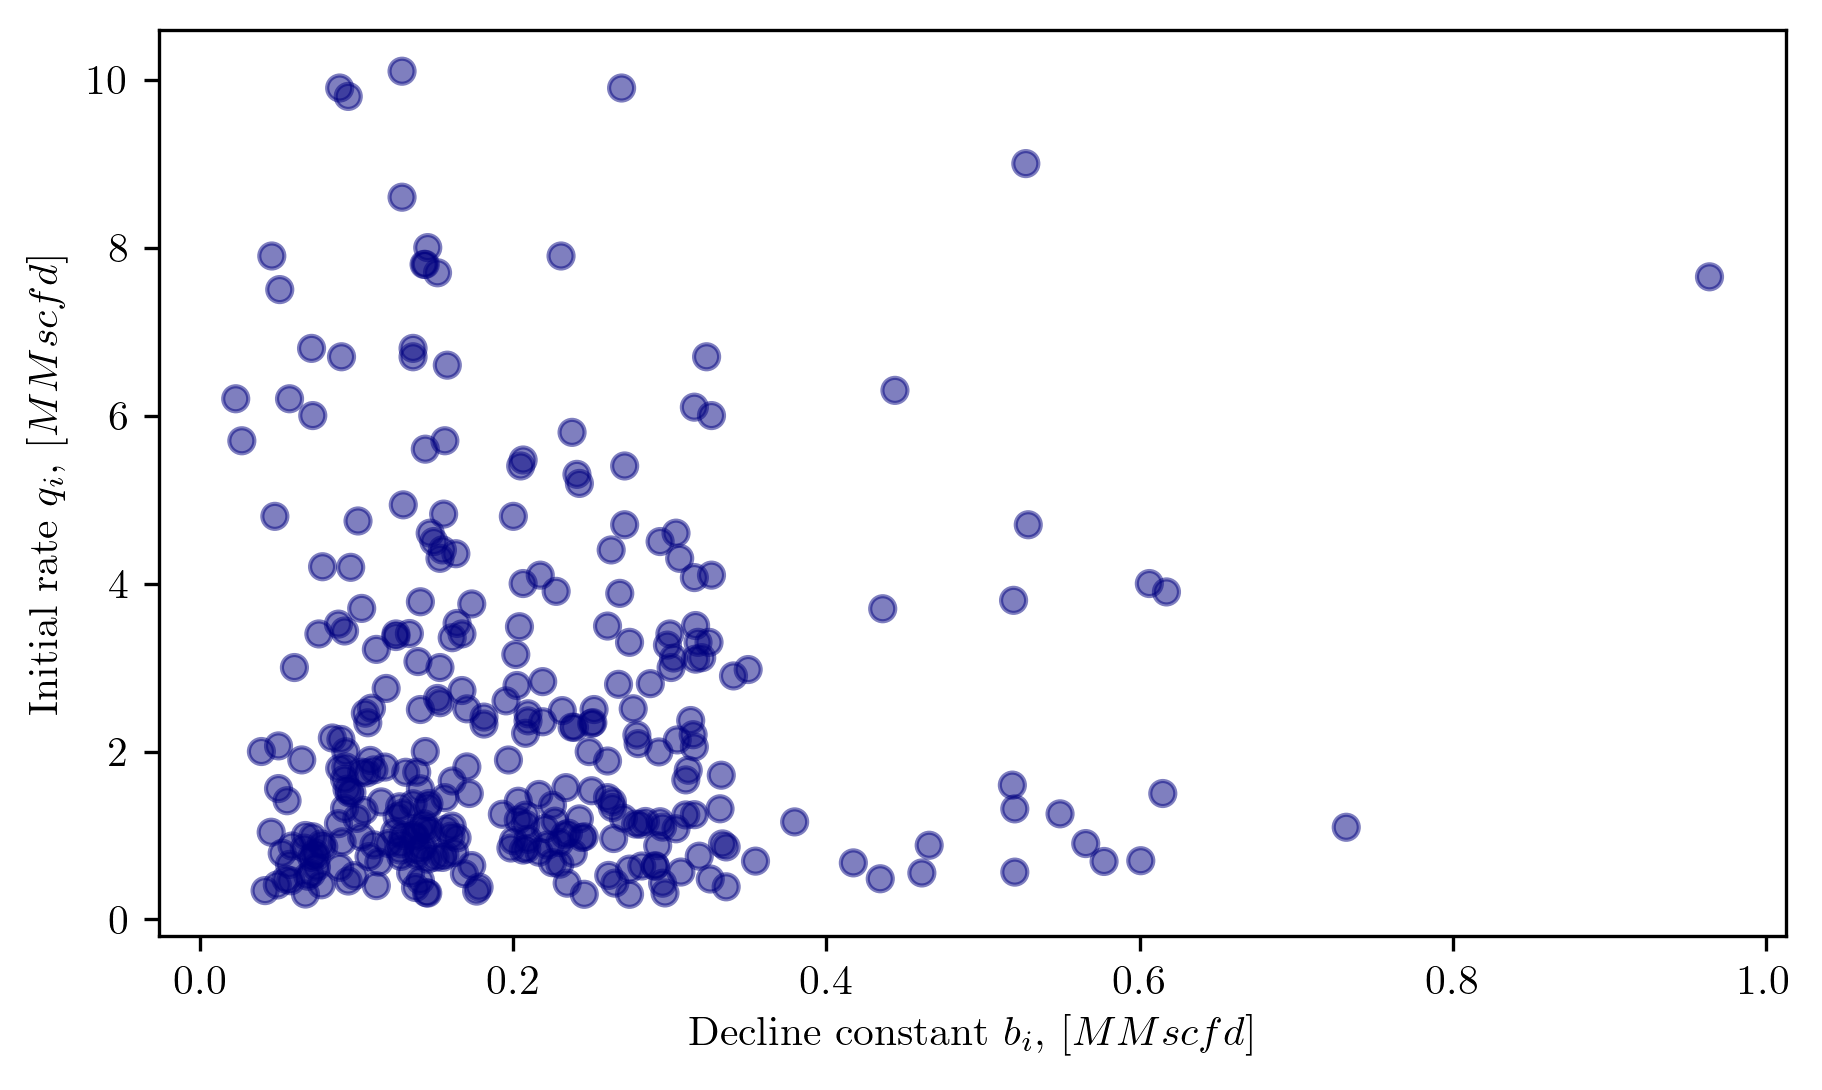

In [16]:
plt.figure(figsize=(7, 4))
plt.scatter(a,b,c=color,alpha=0.5)
plt.xlabel('Decline constant $b_i$, $[MMscfd]$')
plt.ylabel('Initial rate $q_i$, $[MMscfd]$')
##plt.xlim(0.0,0.5)

In [17]:
## Lets join our dataframe
data=pd.DataFrame(list(zip(a,b,der,names,color)),
                 columns=['DeclineExp','InitialRate','Derivative','Field','Color'])

#### Example for a single well

We include an example of how calculation work for a single well.

* We fit our production data using an exponential model. The result of the fit are the predictor features.

In [18]:
q=df['Well 7'].to_numpy() #4
q = q[~np.isnan(q)]
q=q[q!=0]
N=2
q_C=np.convolve(q,np.ones((N,))/N, mode='valid')
Time_C=time_array(q_C)

qi=max(q)
e=np.e

def model(params, X):
    a = params[0]
    y_pred = qi*e**(-a*X)# Exponential decline
    return y_pred
## Loss resistant to outliers
def MAE(params, X, Y):
    y_pred = model(params, X)
    obj = (abs(y_pred - Y).sum())/len(X)
    return obj
def RMSE(params, X, Y):
    y_pred = model(params, X)
    obj = (((y_pred - Y)**2).sum())/len(X)
    return obj

X = Time_C # 
Y = q_C # 
alpha_0 = 0.5


res = minimize(MAE, [alpha_0, ], args=(X, Y), tol=1e-3, method="Nelder-Mead")

# Calculate the qs using the optimized decline exponent $b$
a=res['x'][0] #
qi=q.max()
e=np.e
q=np.zeros(Time_C.shape[0])
for i in range(Time_C.shape[0]):
    q[i]=qi*e**(-a*Time_C[i])
    #q[i]=qi/((1+a*b*Time[i])**(1/a))
    #print(Time[i])

The resulting fit is shown next:

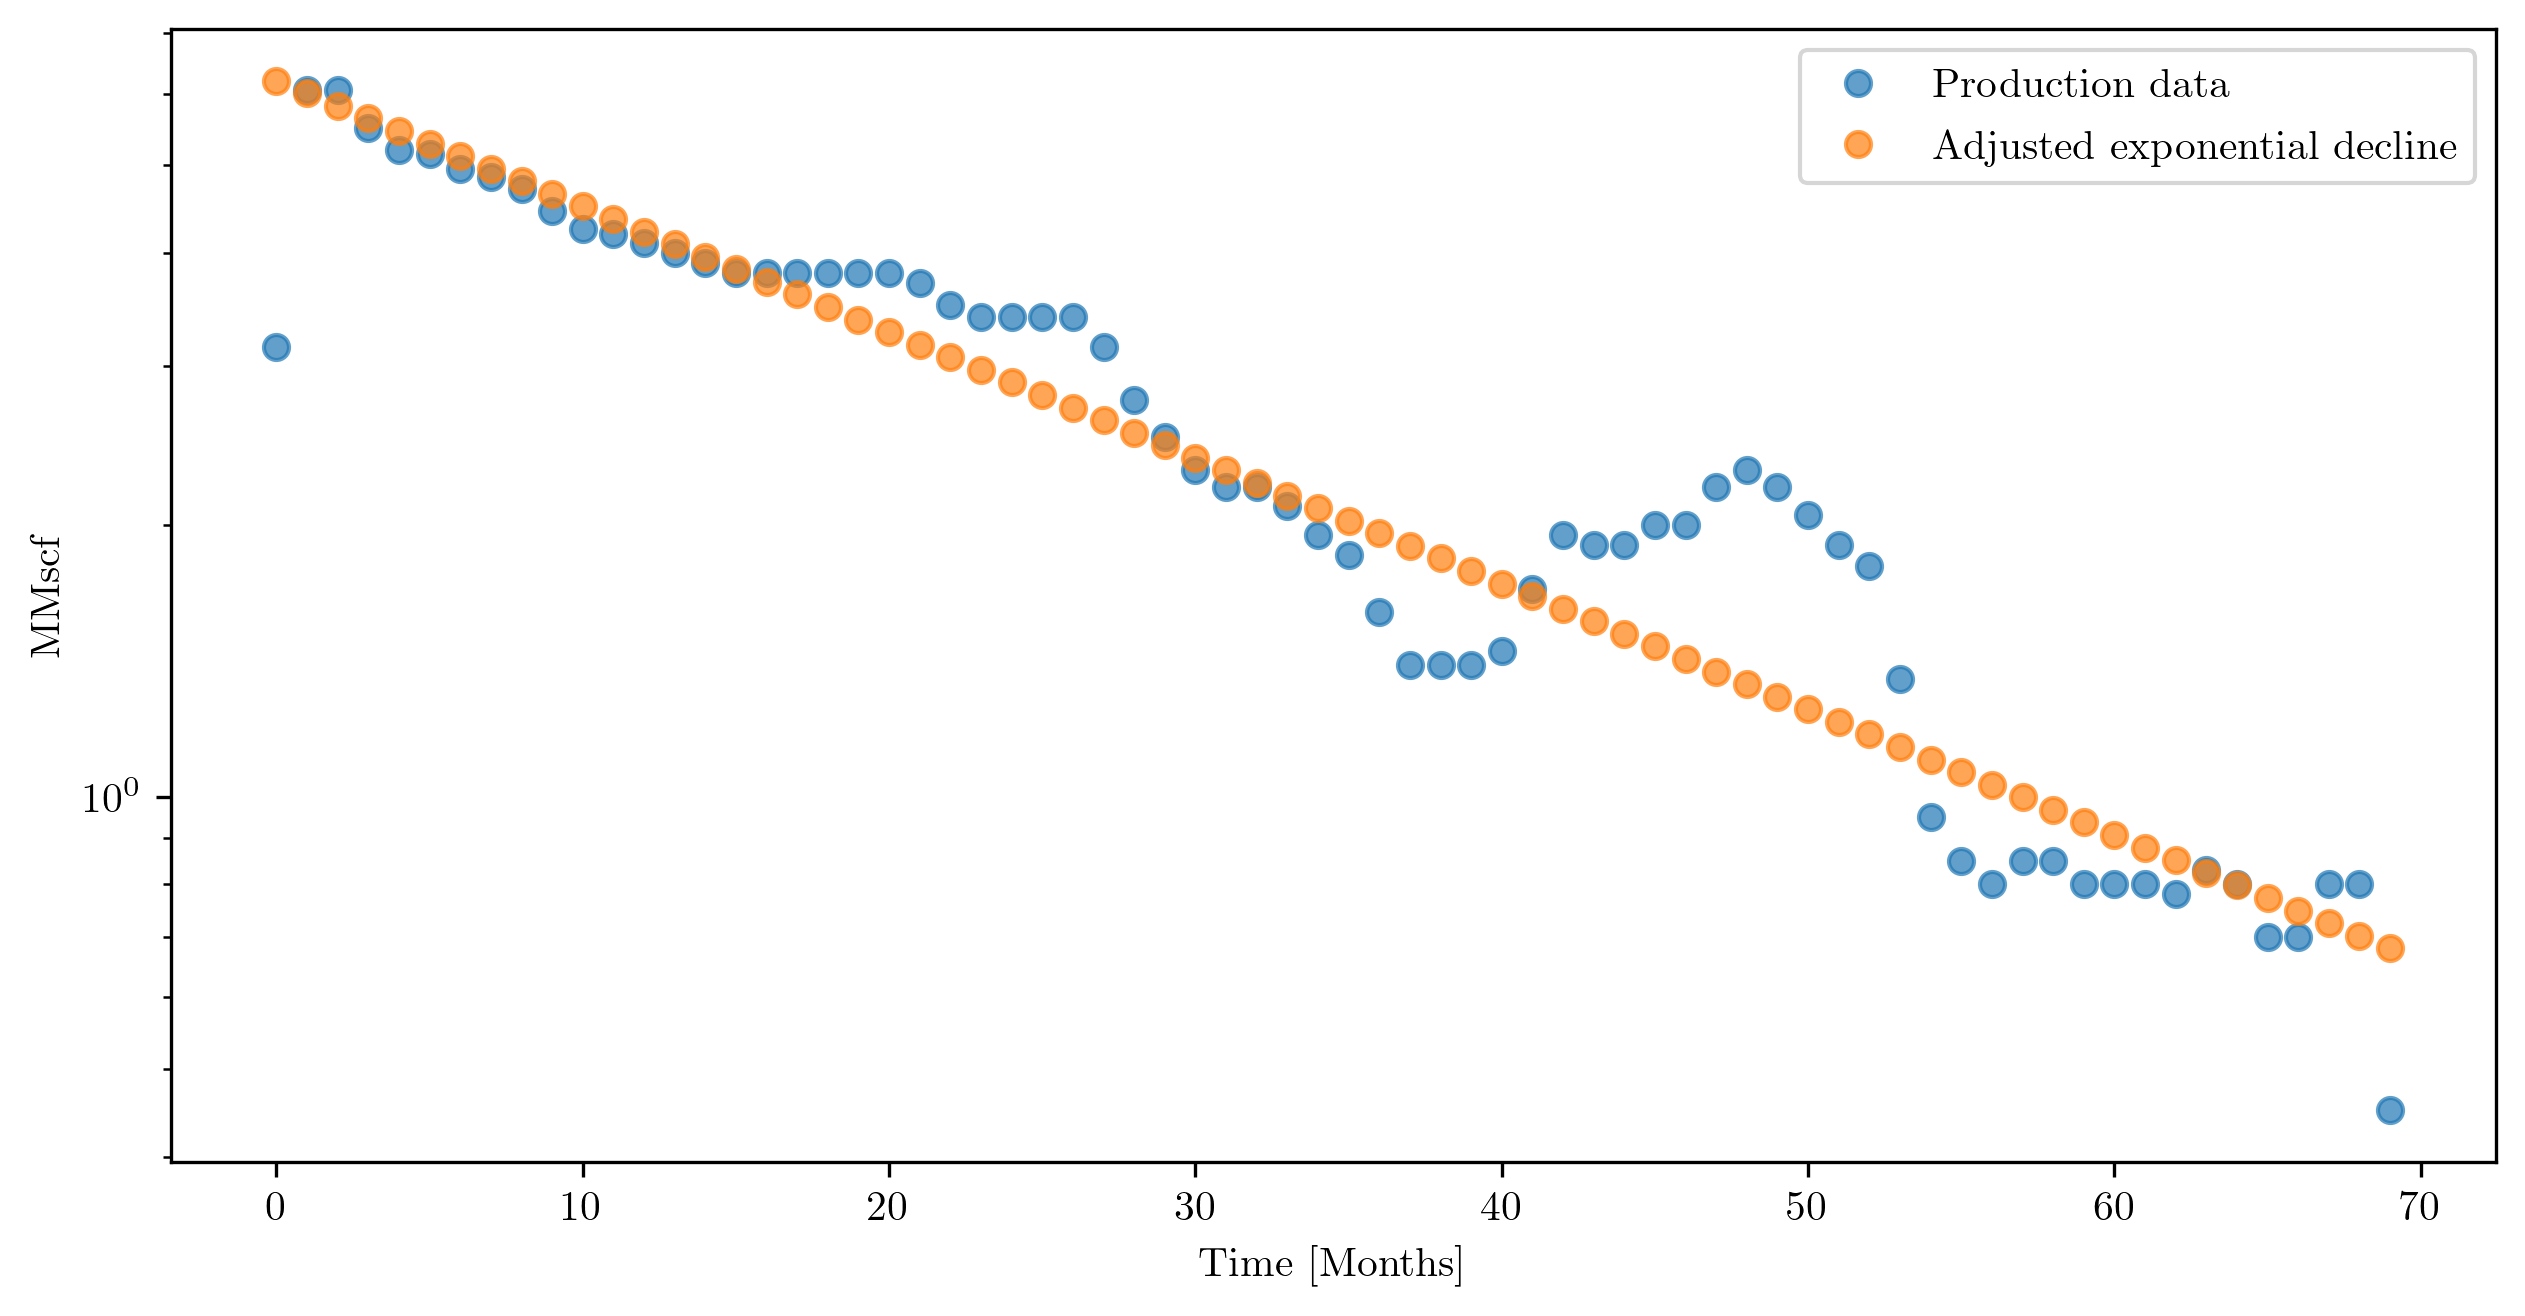

In [19]:
#Plot the results
fig, ax = plt.subplots(figsize=(10, 5))
ax.semilogy(Time_C,q_C,'o',alpha=0.7,label='Production data')
#ax.plot(Time_C,Well_C,'o',alpha=0.7,label='Datos de producción')
ax.semilogy(Time_C,q,'o',alpha=0.7,label='Adjusted exponential decline')
ax.set_ylabel('MMscf')
ax.set_xlabel('Time [Months]')
ax.legend();

### Basic Data Checking and Visualization

Lets check our recently derived dataframe.

In [20]:
data.head()

,DeclineExp,InitialRate,Derivative,Field,Color
0,0.022656,6.2,0.5750,Field1,navy
1,0.125000,3.4,0.2125,Field1,navy
2,0.026562,5.7,0.4125,Field1,navy
3,0.274219,0.3,0.0250,Field1,navy
4,0.057031,6.2,0.5500,Field1,navy


We can also obtain some useful statistics from our dataframe using *describe*

In [21]:
data[['DeclineExp','InitialRate']].describe(percentiles=[0.1,0.5,0.9]).transpose()

,count,mean,std,min,10%,50%,90%,max
DeclineExp,309.0,0.207255,0.128586,0.022656,0.074219,0.173437,0.326562,0.964063
InitialRate,309.0,2.402476,2.078358,0.300000,0.564800,1.570000,5.414200,10.100000


### Feature transformation

We need to transform our data to work between 0 and 1, for this we use the following min_max normalization.

\begin{equation}
X_{normalized} =\frac{X - X_{minimum}}{X_{maximum}-X_{minimum}}
\end{equation}


In [22]:
data['NormDeclineExp']=min_max(data['DeclineExp'])
data['NormInitialRate']=min_max(data['InitialRate'])
data['NormDerivative']=min_max(data['Derivative'])

Lets provide some summary statistics to check our data for inconsistencies. Our normalized data must be bounded between 0 and 1.

In [23]:
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
DeclineExp,309.0,0.207255,0.128586,0.022656,0.118750,0.173437,0.274219,0.964063
InitialRate,309.0,2.402476,2.078358,0.300000,0.900000,1.570000,3.369000,10.100000
Derivative,309.0,0.194920,0.163645,0.016125,0.073875,0.128750,0.277625,0.975000
NormDeclineExp,309.0,0.196088,0.136589,0.000000,0.102075,0.160166,0.267220,1.000000
NormInitialRate,309.0,0.214538,0.212077,0.000000,0.061224,0.129592,0.313163,1.000000
NormDerivative,309.0,0.186464,0.170664,0.000000,0.060227,0.117455,0.272715,1.000000


#### Comparison of scatterplots

We can also compare the scatterplots to check the feature transformations.

Text(0, 0.5, 'Initial rate $q_i$, $[MMscfd]$ (normalized)')

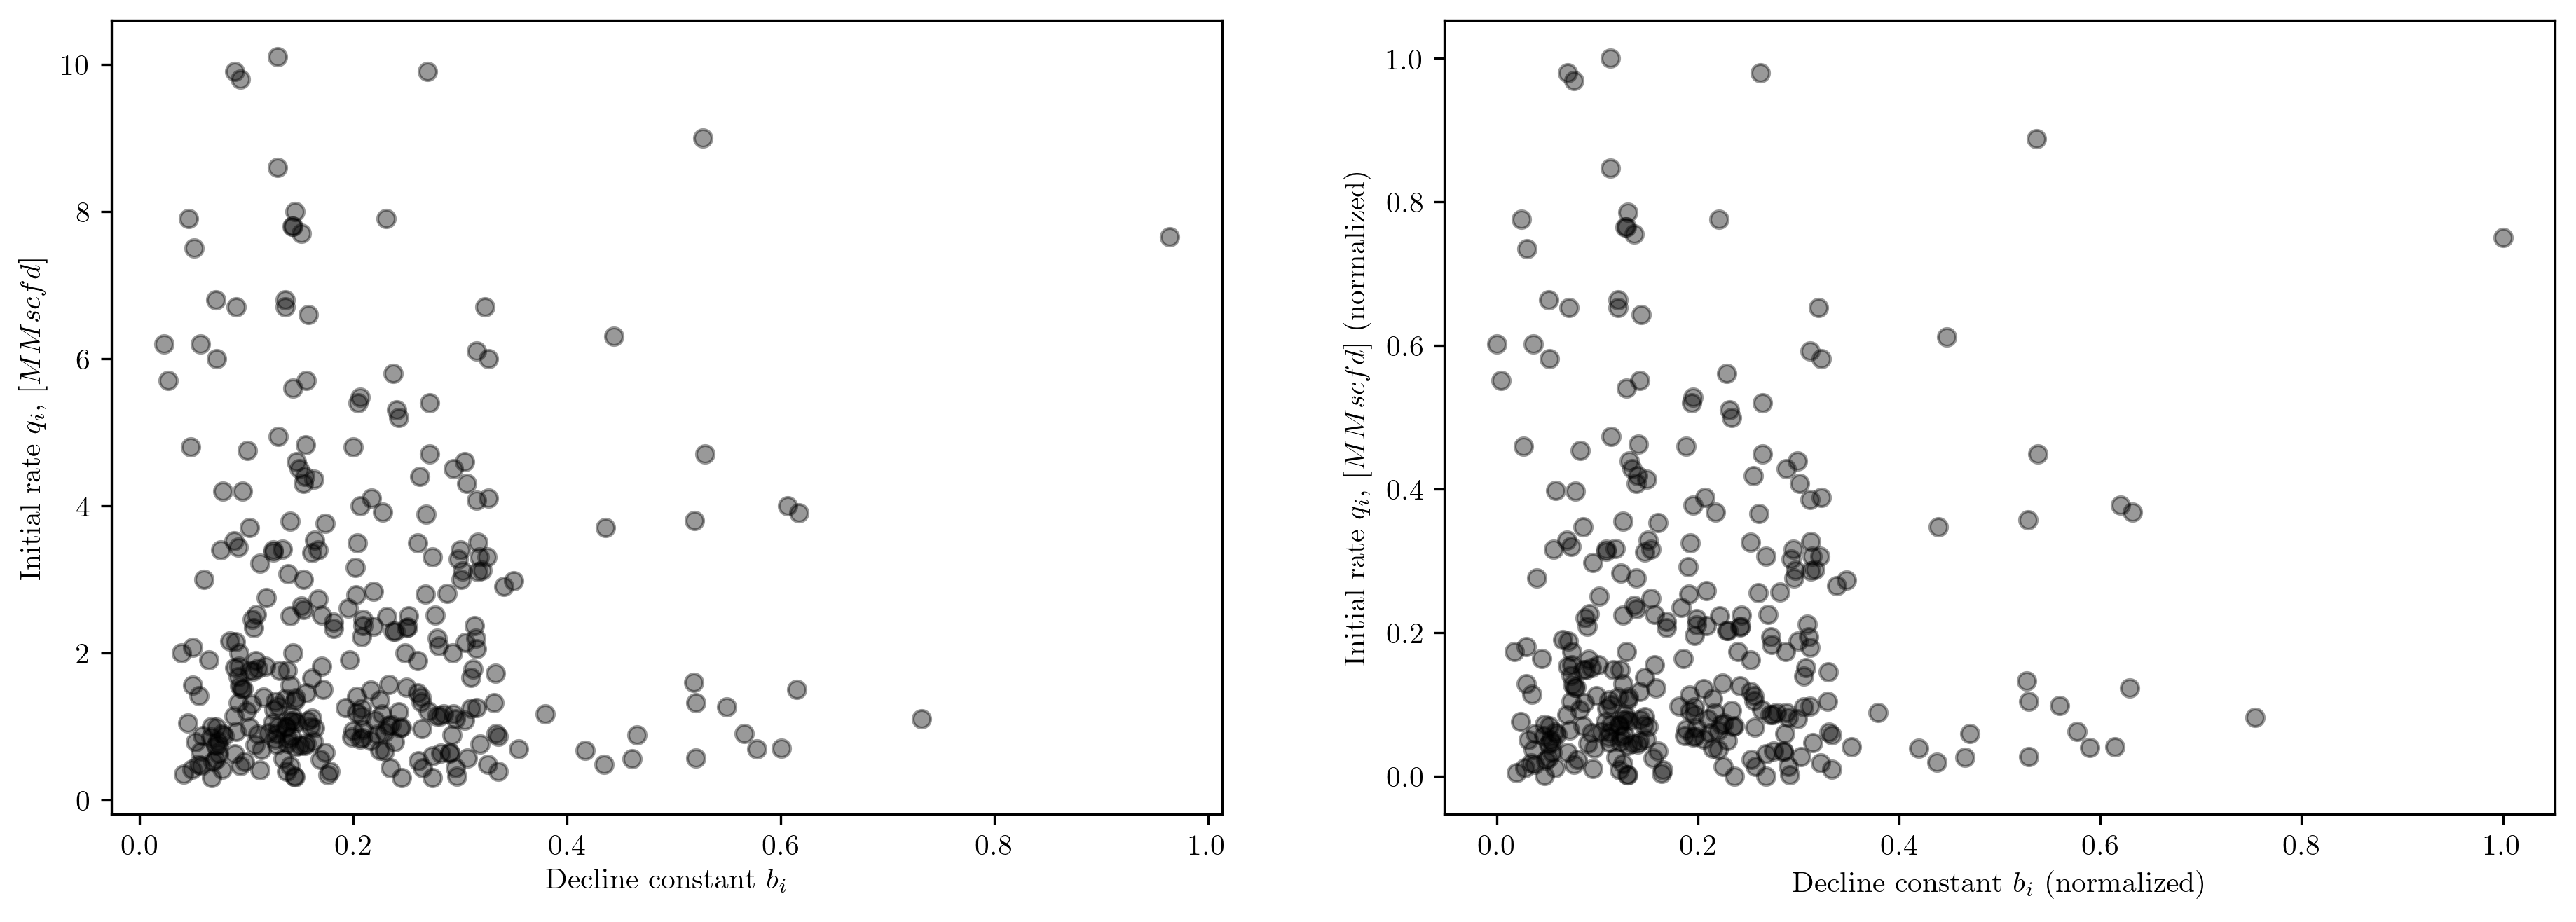

In [24]:
kwargs={'c':"black",
            'alpha':0.4,
            'linewidths':1.0,
            'verts':None,
            'edgecolors':"black"}
# scatter plot our training data
xlabel='Decline constant $b_i$'
ylabel='Initial rate $q_i$, $[MMscfd]$'

plt.figure(figsize=(15,5))
plt.subplot(121)
plt.scatter(data.DeclineExp,
            data.InitialRate,
            **kwargs)
plt.xlabel(xlabel)
plt.ylabel(ylabel)

plt.subplot(122)
plt.scatter(data.NormDeclineExp,
            data.NormInitialRate,
            **kwargs)
plt.xlabel(xlabel + ' (normalized)')
plt.ylabel(ylabel + ' (normalized)')

## Clustering analysis with DBSCAN (Density-based spatial clustering of applications with noise)

DBSCAN requires 2 parameters, ***$\epsilon$*** that specifies how close the points should be to each other to be considered a part of a cluster, and ***min_samples*** the minimum number of samples to form a cluster.

What are the advantages of DBSCAN?
- Minimum domain knowledge to estimate hyperparameters, arbitrary shape clusters and efficient on large datasets.
- All data samples start as their own group
- All samples may belong to only one cluster

$$ P\left(C_{i}\cap C_{j}\mid i\neq j\right)=0 $$

- Non exhaustive, we can detect outliers

$$P\left(C_{1}\cup C_{2}\cup\cdots\cup C_{k}\right)\leq1$$


The algorithm is as follows(Pyrcz, 2020):

1. All points are labled as unvisited

2. Randomly visit an unvisited sample

3. Check if a core point ($ge$ min_sample within eps distance), if so label as core otherwise label as outlier

4. Now visit all points within eps distance of the core point, determine if core, otherwise label as border point

5. Recusive operation where all points within eps distance of new core points are checked

6. Once this is exhausted then randomly visit an unvisited point



Using the resulting number of clusters we can move to spectral declustering.

In [25]:
NFeatures=['NormDeclineExp','NormInitialRate']
Features=['DeclineExp','InitialRate']

### Hyperparameter search

To determine the first parameter $\epsilon$ we use Nearest Neighbour distance in normalized feature space for all the sample data, we select the distance that maximizes the positive curvature.

Text(0.5, 1.0, 'Nearest Neighbour ')

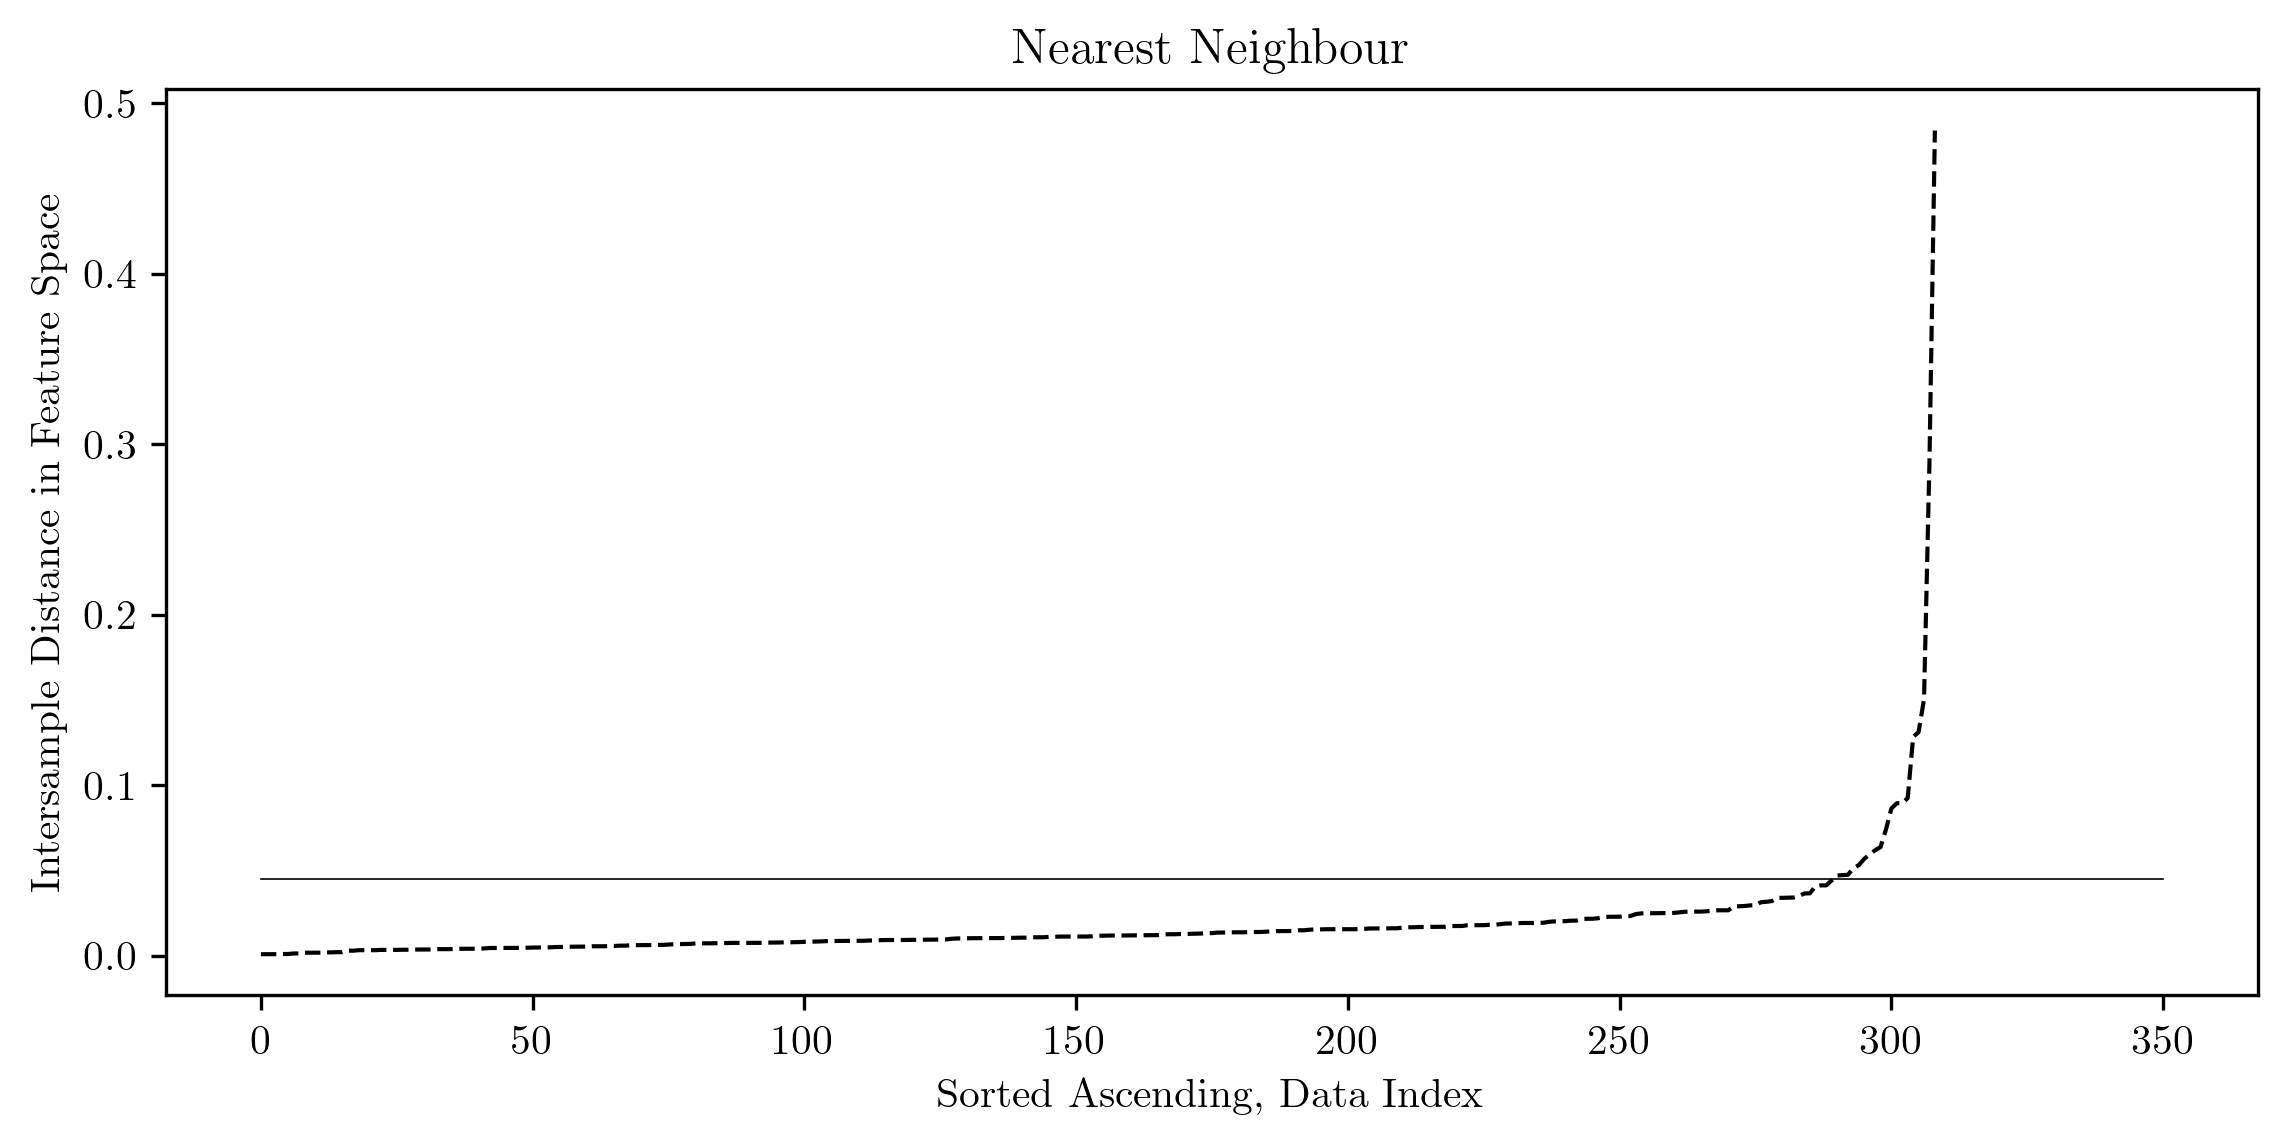

In [26]:
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(data[[NFeatures[0],NFeatures[1]]].values)
distances, indices = nbrs.kneighbors(data[[NFeatures[0], NFeatures[1]]].values)
distances = np.sort(distances, axis=0)
distances = distances[:,1]

plt.figure(figsize=(9, 4))
plt.plot(distances,'--k',linewidth=1); 
plt.plot([0,350],[0.045,0.045], c = 'k',linewidth=0.4);
plt.xlabel('Sorted Ascending, Data Index'); plt.ylabel('Intersample Distance in Feature Space')
plt.title('Nearest Neighbour ')


### DBSCAN

Let's use DBSCAN and the selected EPS from the previous step to fit our data.

In [27]:
dbscan = DBSCAN(eps=0.03, min_samples=5).fit(data[NFeatures].values)
data['DBSCAN'] = dbscan.labels_ + 1
cmap='viridis'

#### DBSCAN Results

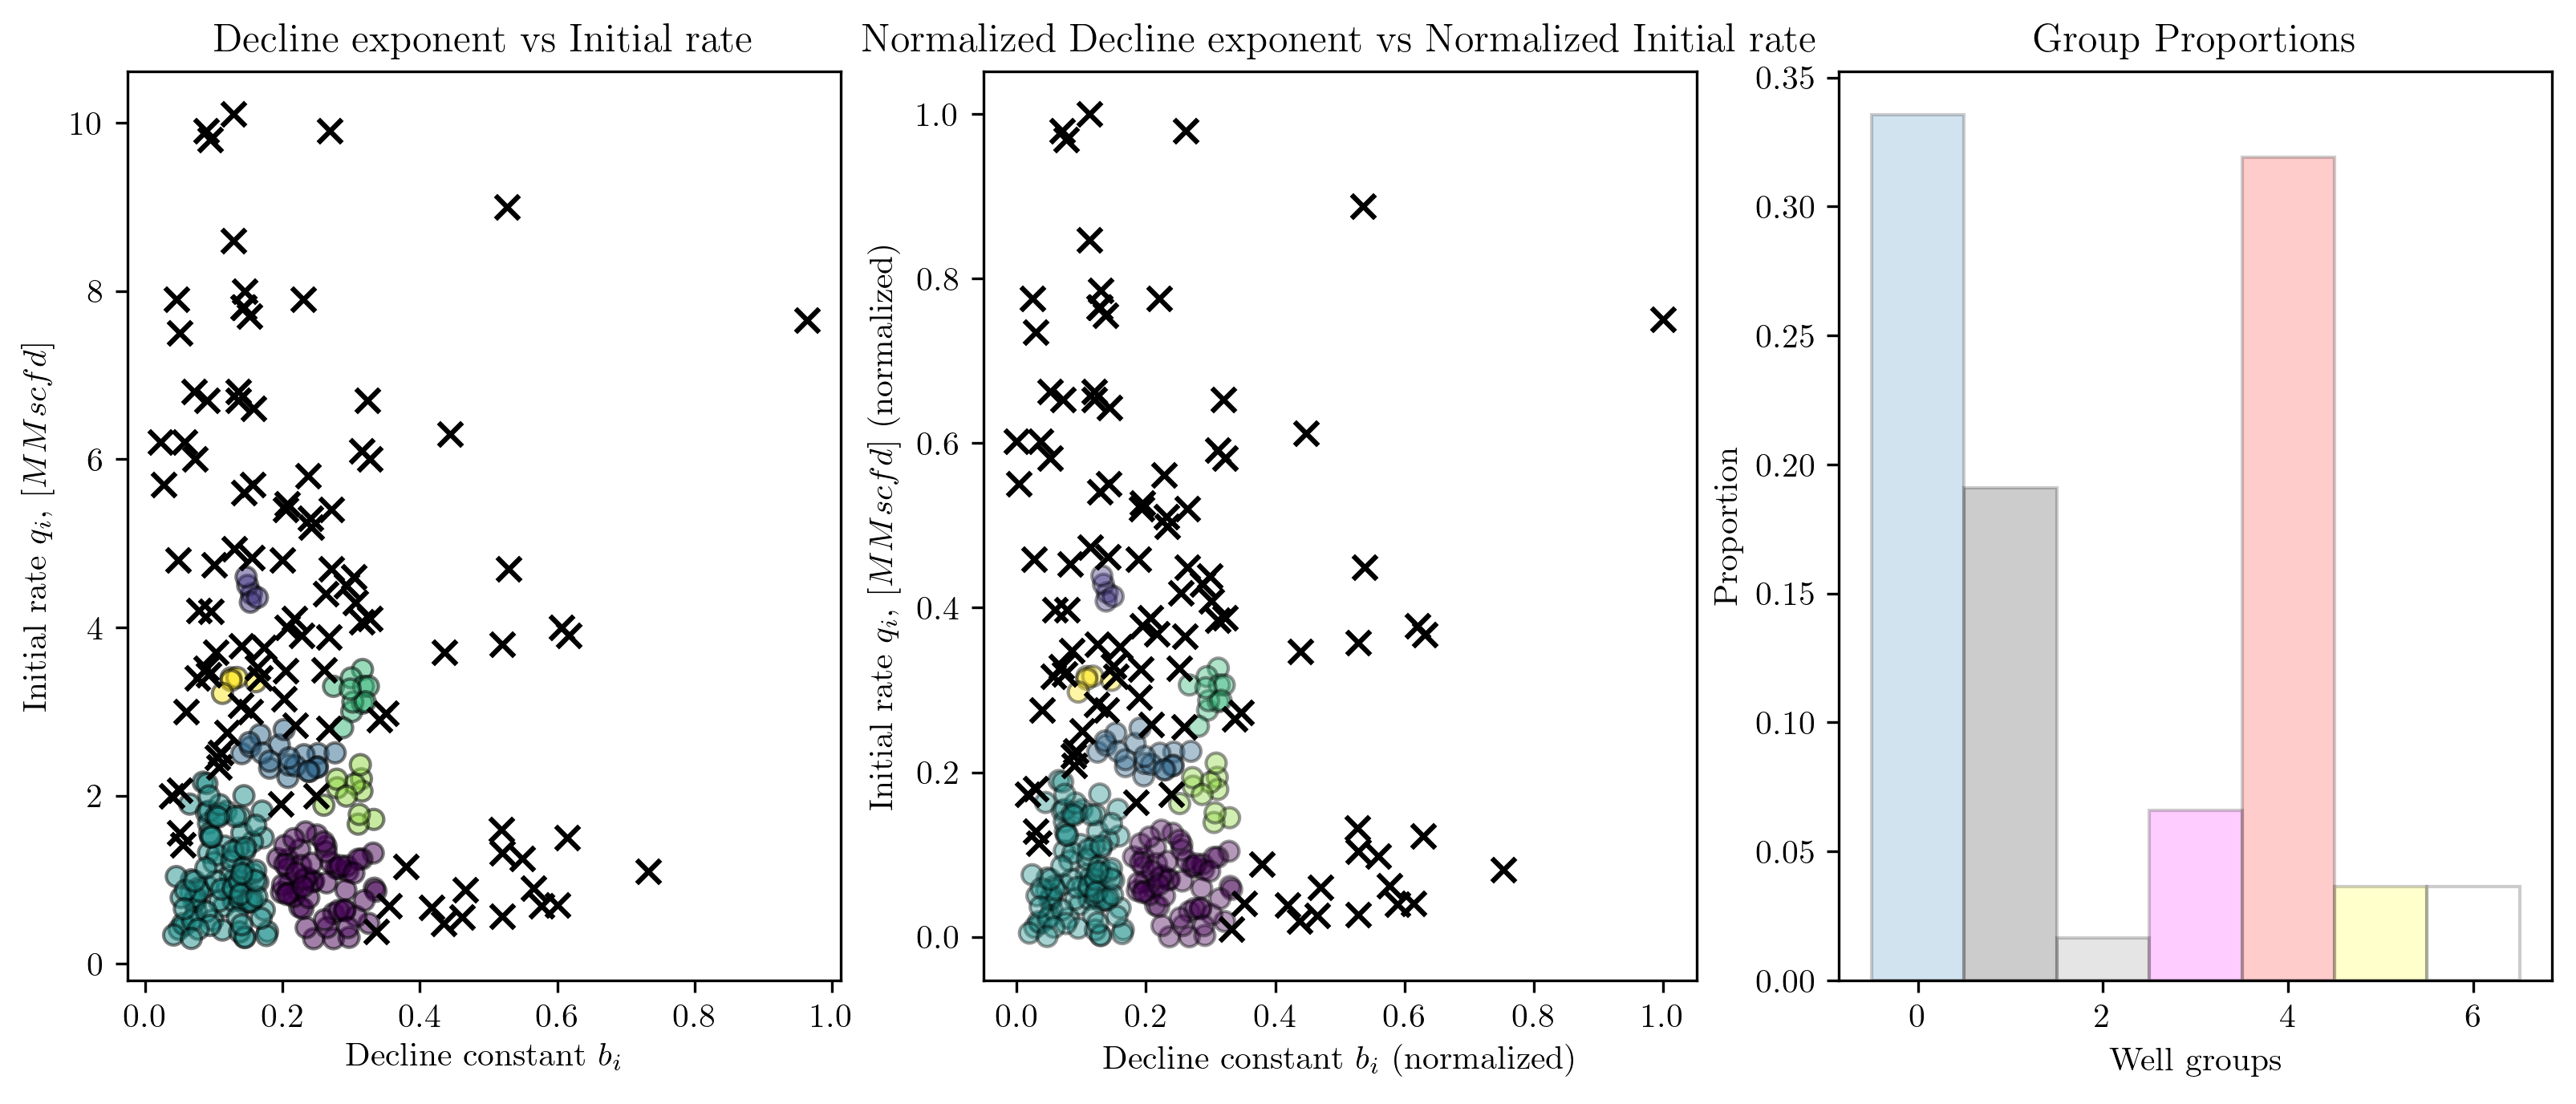

In [28]:
'''
Code adapted from SubsurfaceDataAnalytics_advanced_clustering.ipynb
in-class workflow.
'''

plt.figure(figsize=(13,5))
plt.subplot(131)   
data_in = data.loc[(data['DBSCAN'] != 0)]
plt.scatter(data_in[Features[0]], data_in[Features[1]], c=data_in['DBSCAN'], alpha=0.5, edgecolor='k', cmap = cmap)
data_outlier = data.loc[(data['DBSCAN'] == 0)]
plt.scatter(data_outlier[Features[0]],data_outlier[Features[1]],c='black',s = 50,marker = 'x',edgecolor='k',cmap = cmap)
plt.title('Decline exponent vs Initial rate' )
plt.xlabel(xlabel)
plt.ylabel(ylabel)

plt.subplot(132)      
plt.scatter(data_in[NFeatures[0]], data_in[NFeatures[1]], c=data_in['DBSCAN'], alpha = 0.4, linewidths=1.0, verts=None, edgecolors="black", cmap = cmap)
plt.scatter(data_outlier[NFeatures[0]],data_outlier[NFeatures[1]],c='black',s = 50,marker = 'x',edgecolor='k',cmap = cmap)

plt.title('Normalized Decline exponent vs Normalized Initial rate')
plt.xlabel(xlabel + ' (normalized)')
plt.ylabel(ylabel + ' (normalized)')

plt.subplot(133)
N, bins, patches  = plt.hist(data['DBSCAN'],alpha=0.2,edgecolor="black",bins=[-0.5,0.5,1.5,2.5,3.5,4.5,5.5,6.5],range=[0.5,2.5],density = True)
patches[1].set_facecolor('black'); patches[3].set_facecolor('magenta'); patches[4].set_facecolor('red')
patches[5].set_facecolor('yellow'); patches[6].set_facecolor('white'); patches[2].set_facecolor('gray');
plt.title('Group Proportions')
plt.xlabel('Well groups')
plt.ylabel("Proportion")
ax = plt.gca()

## Results

The following figures show the final results from both DBSCAN and spectral declustering. The idea to use DBSCAN first was to obtain a minimum number of clusters followed by spectral declustering and the use of the graph and how the data is clustered by partitioning this graph.

DBSCAN identifies many wells as outliers. Specially those whose initial production was too high or too low.


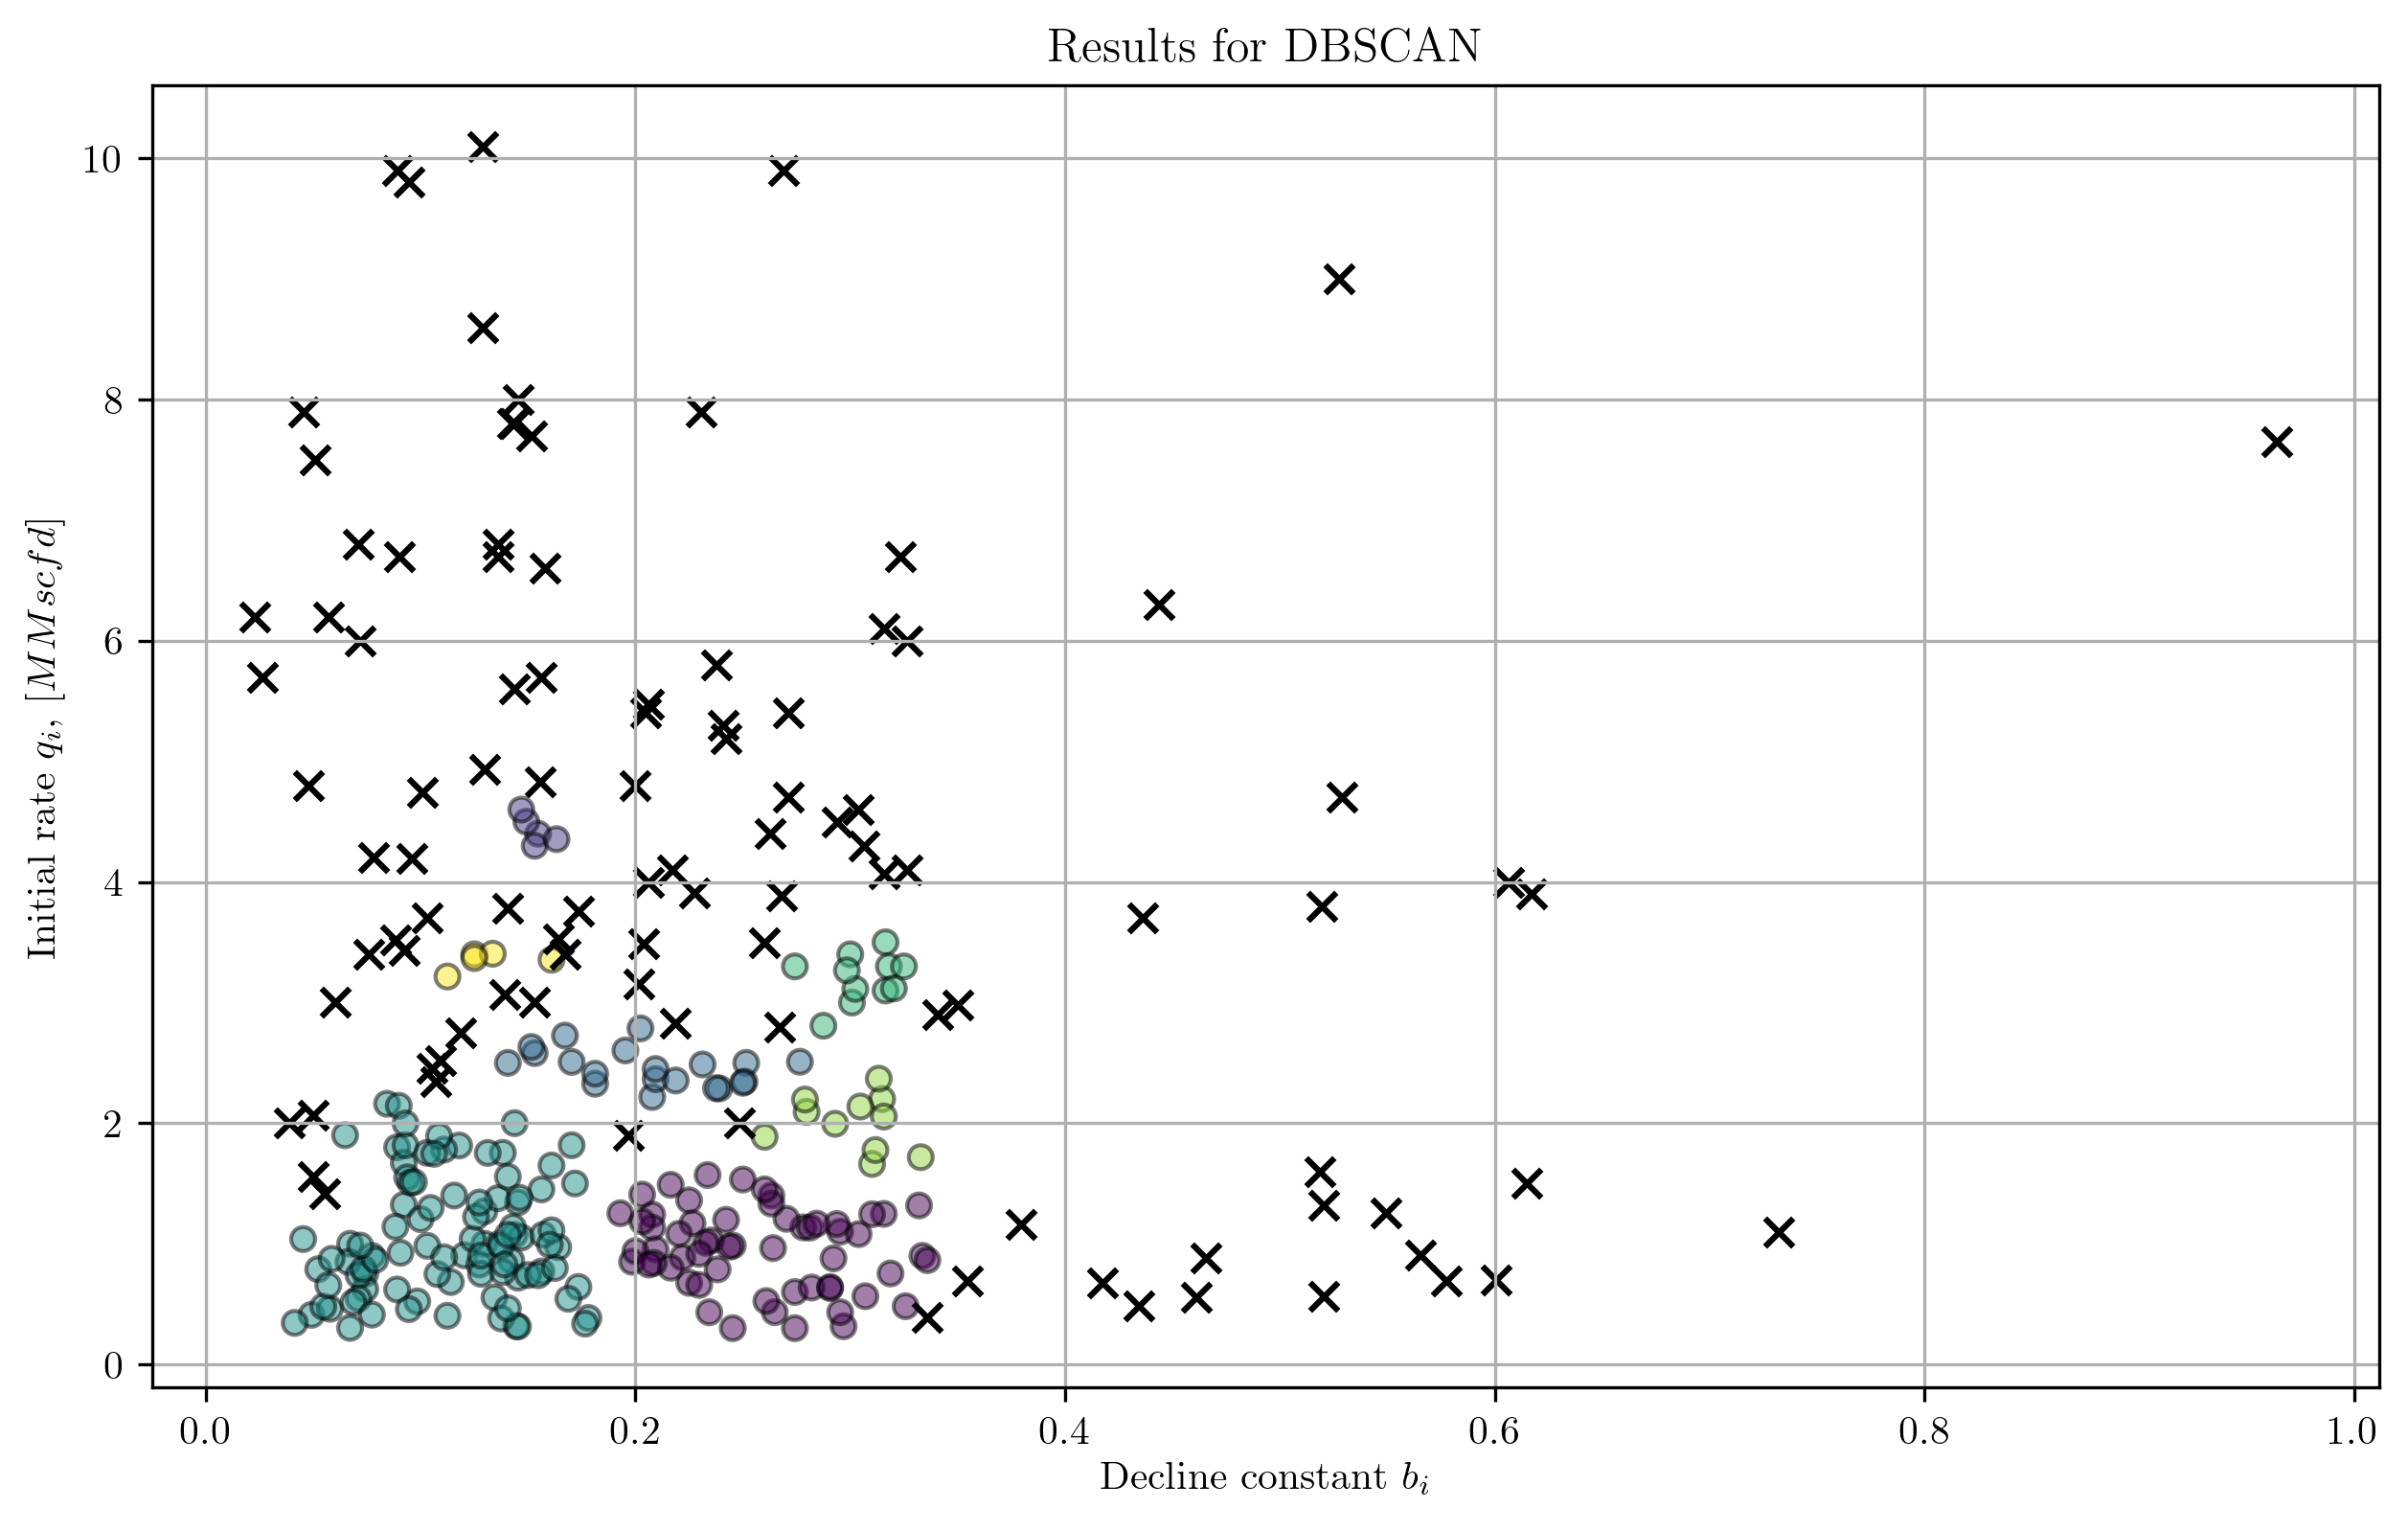

In [29]:
plt.figure(figsize=(10,6))
nplot=0
plt.scatter(data_in[Features[0]], data_in[Features[1]], c=data_in['DBSCAN'], alpha=0.5, edgecolor='k')
plt.scatter(data_outlier[Features[0]],data_outlier[Features[1]],c='black',s = 50,marker = 'x',edgecolor='k',cmap = cmap)
plt.title('Results for DBSCAN')
plt.grid()
plt.xlabel(xlabel); 
plt.ylabel(ylabel);



* By using a clustering algorithms that take advantage of the minimum distance between data points we can find outliers in our groups of wells. 

* Many of these wells exhibit unusually large initial production or unually large decline exponent that is correspondent to a low initial rate. 

* The resulting cluster groups can be later compared with other wells using petrophysical information, location, and time. We can use this information to estimate ultimate recovery from wells since many of the wells grouped here have distinctive initial rates followed by a unique decline exponent.

* Using this workflow we detect patterns in the predictor feature space that goes beyond proximity in the predictor feature space. 

* This workflow can provide a hint useful to identify misclassification and raise flags on wells that behave differently from others.

### Comparison with a known field

We compare our derived groups with a known field. We know that some of the wells are producing from different formations and some of these reservoirs are overpressured. Let's see if our workflow can identify and help us group such wells.

In [32]:
df = pd.read_csv('PGE_Project_Eduardo_Maldonado_Data_FieldRates.csv')
df=df.fillna(0)
Rate=df.loc[:,df.columns.str.startswith('Well')].to_numpy()
Rate=np.nan_to_num(Rate)
Time=time_array(Rate)

#Read the csv file
df_names = pd.read_csv('PGE_Project_Eduardo_Maldonado_Data_FieldNames.csv',encoding='utf-8')

a=[]
b=[]
names=[]
color=[]
der=[]
i=1
for key in df_names.Field:
    if key=='Field_test_2':
        q=Rate[:,i]
        q=q[q!=0]
        qi=Rate[:,i].max()
        if len(q)<6:
            index_to_drop.append(i)
        if len(q)>6:
            N=2
            # Curve smoothing
            q_C=np.convolve(q,np.ones((N,))/N, mode='valid')
            derivative=diff(q_C)
            #print(derivative)
            t_C=time_array(q_C)
            X = t_C[:8] # 
            Y = q_C[:8] # 
            alpha_0 = 0.5
            # Decline exponent minimization
            res = minimize(MAE, [alpha_0, ], args=(X, Y), tol=1e-3, method="Nelder-Mead")
            # The nomial decline exponent is defined as the fractional hange in rate per unit of time
            # where this exponent is positive
            if res['x']<1:
                a.append(res['x'][0])
                #print(res['x'][0])
                names.append(str(key))
                color.append(str(colmap[str(key)]))
                der.append(max(abs(derivative)))
                #timeder.append(t_C[np.argmax(derivative)])
                #print(max((dR[:,i])))
                #b.append(sum(t_C))
                #b.append(sum(q))
                #The second parameter selected was initial rate
                b.append(qi)
                index_to_keep.append(i)
            else:
                index_to_drop.append(i)
            well_index.append(i)
    i=i+1

We can use this workflow along with additional data to include other features in our scatterplot.

In [33]:
data_in.head()

,DeclineExp,InitialRate,Derivative,Field,Color,NormDeclineExp,NormInitialRate,NormDerivative,DBSCAN
1,0.125000,3.400,0.212500,Field1,navy,0.108714,0.316327,0.204797,7
3,0.274219,0.300,0.025000,Field1,navy,0.267220,0.000000,0.009256,1
5,0.274219,0.600,0.050000,Field1,navy,0.267220,0.030612,0.035328,1
10,0.316406,3.500,0.350000,Field1,navy,0.312033,0.326531,0.348194,5
14,0.235156,1.027,0.116125,Field1,navy,0.225726,0.074184,0.104289,1


Lets isolate our points to plot some nice areas!

(0, 5)

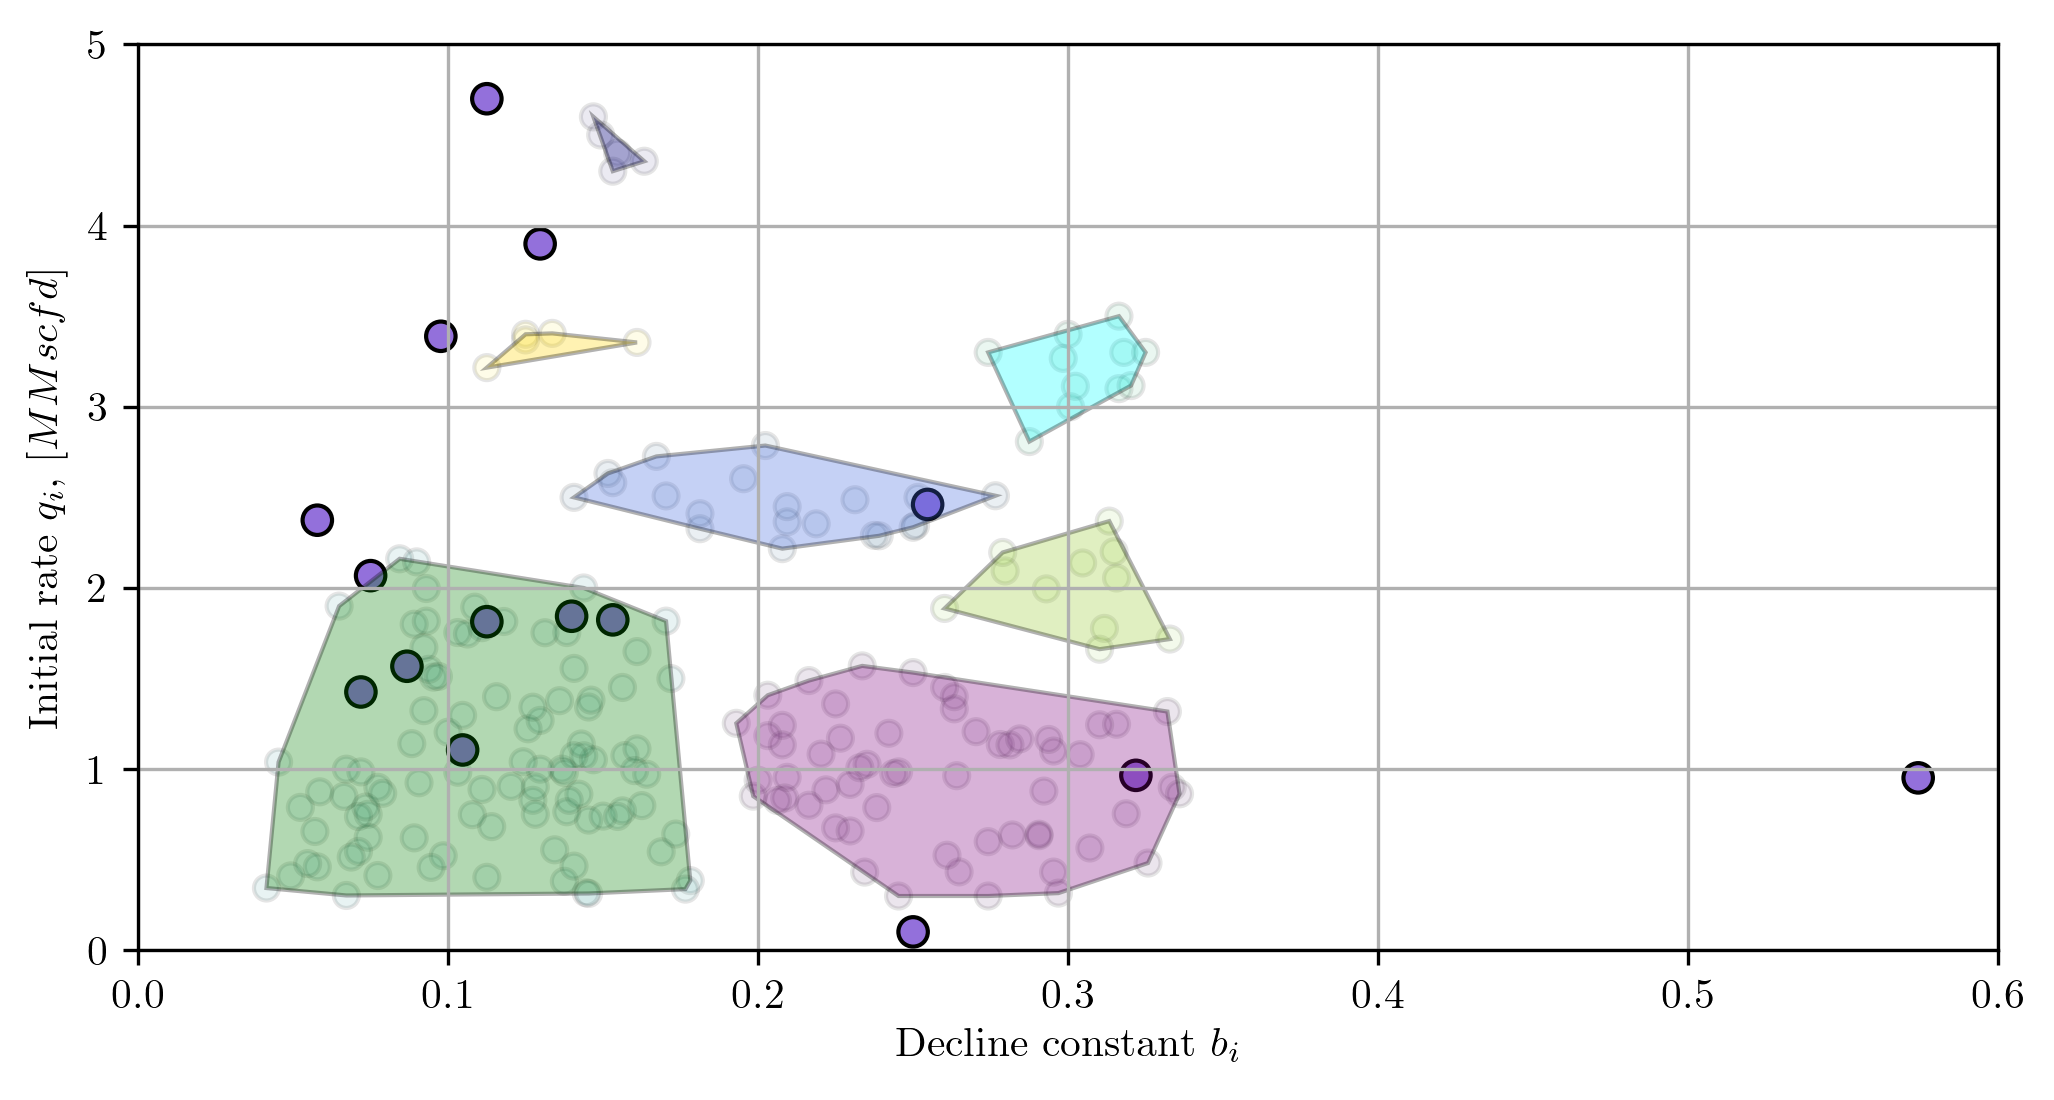

In [34]:
data_in_1=data_in[data_in['DBSCAN']==1]
data_in_2=data_in[data_in['DBSCAN']==2]
data_in_3=data_in[data_in['DBSCAN']==3]
data_in_4=data_in[data_in['DBSCAN']==4]
data_in_5=data_in[data_in['DBSCAN']==5]
data_in_6=data_in[data_in['DBSCAN']==6]
data_in_7=data_in[data_in['DBSCAN']==7]
plt.figure(figsize=(8,4))
nplot=0
plt.scatter(data_in[Features[0]], data_in[Features[1]], c=data_in['DBSCAN'], alpha=0.1, edgecolor='k')
plt.scatter(a,b,c=color,s = 50,marker = 'o',edgecolor='k')
encircle(data_in_1[Features[0]], data_in_1[Features[1]], ec="k", fc="purple", alpha=0.3)
encircle(data_in_2[Features[0]], data_in_2[Features[1]], ec="k", fc="navy", alpha=0.3)
encircle(data_in_3[Features[0]], data_in_3[Features[1]], ec="k", fc="royalblue", alpha=0.3)
encircle(data_in_4[Features[0]], data_in_4[Features[1]], ec="k", fc="green", alpha=0.3)
encircle(data_in_5[Features[0]], data_in_5[Features[1]], ec="k", fc="cyan", alpha=0.3)
encircle(data_in_6[Features[0]], data_in_6[Features[1]], ec="k", fc="yellowgreen", alpha=0.3)
encircle(data_in_7[Features[0]], data_in_7[Features[1]], ec="k", fc="gold", alpha=0.3)
plt.grid()
plt.xlabel(xlabel); 
plt.ylabel(ylabel);
plt.xlim(0,0.6)
plt.ylim(0,5)

#### Observations, conclusions

The following information is known for the test field and the analogue field.

* Some of these wells are overpressured, leading to unusually high production rates at the begining of the production.
* Some of them are small gas pockets with low drainage area. High rates and fast decline.
* Some wells are producing from completely different formations. There is no correlation between the wells.
    * From the figure, these wells are not included in any observed cluster of the analogue.

* Some wells have similar initial and decline rates. We can use these wells as analogues in case we do not have any information! Because they share similar static and dynamic properties.

**What would happen if we have information about skin or liquid loading?**

* We can incorporate this information in our plots to identify potential problems and solutions!.

### Parting Comments

This is a basic demonstration of how we can derive features from production data and the use of clustering as an inferential method.

Much more can be done!

I am a petroleum engineer who is always looking for new challenges and always searching for innovative solutions. I am eager to learn new technologies and develop my own solutions. I have more than two years of field experience as reservoir engineer and one year of research in data analytics and machine learning. I am experienced in development and execution of projects and research at both university and field applications. I am interested in internship opportunities where I look forward to contribute with my technical experience and positive thinking.

I hope this was helpful,

**Eduardo Maldonado Cruz**

emaldonadocruz@utexas.edu
    
[LinkedIn](https://www.linkedin.com/in/eduardo-maldonado-8386a898/)

### References

 1 Arps, J. J. (1945, December 1). Analysis of Decline Curves. Society of Petroleum Engineers. doi:10.2118/945228-G
 
 2 Bach, F. and Jordan, M. (2004). Learning spectral clustering. In S. Thrun, L. Saul, and B. Sch ̈olkopf (Eds.),Advances in Neural Information Processing Systems 16 (NIPS)(pp. 305 – 312). Cambridge, MA: MITPress.
 
 3 Von Luxburg, U. (2007). A tutorial on spectral clustering. Statistics and computing, 17(4), 395-416. 

 4 Pyrcz, M.J. (2020). Subsurface Machine Learning Course [PowerPoint presentation].

___________________

#### Work Supervised by:

### Michael Pyrcz, Associate Professor, University of Texas at Austin 
*Novel Data Analytics, Geostatistics and Machine Learning Subsurface Solutions*

With over 17 years of experience in subsurface consulting, research and development, Michael has returned to academia driven by his passion for teaching and enthusiasm for enhancing engineers' and geoscientists' impact in subsurface resource development. 

For more about Michael check out these links:

#### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

#### Want to Work Together?

I hope this content is helpful to those that want to learn more about subsurface modeling, data analytics and machine learning. Students and working professionals are welcome to participate.

* Want to invite me to visit your company for training, mentoring, project review, workflow design and / or consulting? I'd be happy to drop by and work with you! 

* Interested in partnering, supporting my graduate student research or my Subsurface Data Analytics and Machine Learning consortium (co-PIs including Profs. Foster, Torres-Verdin and van Oort)? My research combines data analytics, stochastic modeling and machine learning theory with practice to develop novel methods and workflows to add value. We are solving challenging subsurface problems!

* I can be reached at mpyrcz@austin.utexas.edu.

I'm always happy to discuss,

*Michael*

Michael Pyrcz, Ph.D., P.Eng. Associate Professor The Hildebrand Department of Petroleum and Geosystems Engineering, Bureau of Economic Geology, The Jackson School of Geosciences, The University of Texas at Austin
